In [3]:
import json

import gpytorch
import numpy as np
import torch
from matplotlib import pyplot as plt

from LDGD.visualization import plot_results_gplvm
from LDGD.settings import Settings, Paths
from LDGD.model.utils import ARDRBFKernel
from LDGD.model import LDGD

from LDGD.visualization.animated_visualization import animate_train
from LDGD.visualization.vizualize_utils import plot_heatmap
from LDGD.data.data_loader import load_dataset
from LDGD.model.Autoencoder import VAE

from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

In [4]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_epochs_train': 200,
    'num_epochs_test': 200,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.2
}

In [5]:
np.random.seed(model_settings['random_state'])
torch.manual_seed(model_settings['random_state'])

# Create Dataset


In [6]:
def create_dataset(num_dimension, random_state, test_size, **kwargs):
    # Extract parameters for synthetic data generation
    pattern = kwargs.get('pattern', 'moon')  # default pattern
    n_samples = kwargs.get('n_samples', 500)
    noise = kwargs.get('noise', 0.1)
    increase_method = kwargs.get('increase_method', 'linear')

    X, y, orig_data = generate_data(pattern, n_samples, noise, num_dimension, increase_method, random_state=random_state)
    # One-hot encode the labels
    y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
    y_one_hot[np.arange(y.shape[0]), np.uint(y)] = 1

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(X, y_one_hot, y,
                                                                                       test_size=test_size,
                                                                                       random_state=random_state)
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train_labels)
    y_test_labels_tensor = torch.tensor(y_test_labels)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data

In [7]:
# load raw data
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test = load_dataset(dataset_name=settings.dataset,
                                                                               test_size=0.8,
                                                                               n_features=model_settings['n_features'],
                                                                               random_tate=random_state)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=yn_train.shape[-1],
            hidden_dim=10,
            latent_dim=2,
            num_classes=len(np.unique(labels_train))).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.fit(x=yn_train, y=labels_train, optimizer=optimizer, epochs=100, batch_size=500)
y_hat, mean, log_var, metrics = model.evaluate(yn_test, labels_test)

 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\torch\nn\modules\container.py:139: UserWarning:Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Epoch 1: 	Average Loss:  0.9107889404296875	 REC Loss:  0.7334812622070312	 CLS Loss:  0.1368434295654297	 KL Loss:  0.040464218139648435
	Epoch 2: 	Average Loss:  0.908177978515625	 REC Loss:  0.7311409912109375	 CLS Loss:  0.1368411560058594	 KL Loss:  0.04019579696655273
	Epoch 3: 	Average Loss:  0.9078892211914062	 REC Loss:  0.731217529296875	 CLS Loss:  0.13673590087890625	 KL Loss:  0.03993577575683594
	Epoch 4: 	Average Loss:  0.9041927490234375	 REC Loss:  0.72776904296875	 CLS Loss:  0.13674905395507814	 KL Loss:  0.039674709320068356
	Epoch 5: 	Average Loss:  0.9034006958007812	 REC Loss:  0.7272227783203125	 CLS Loss:  0.13675666809082032	 KL Loss:  0.03942127227783203
	Epoch 6: 	Average Loss:  0.9017339477539063	 REC Loss:  0.7258380126953125	 CLS Loss:  0.13672428894042968	 KL Loss:  0.039171627044677734
	Epoch 7: 	Average Loss:  0.9013681640625	 REC Loss:  0.7257846069335937	 CLS Loss:  0.136656005859375	 KL Loss:  0.038927566528320315
	Epoch 8: 	Average Loss:  0.899411

 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision is ill-defined and being set to 0.0 in

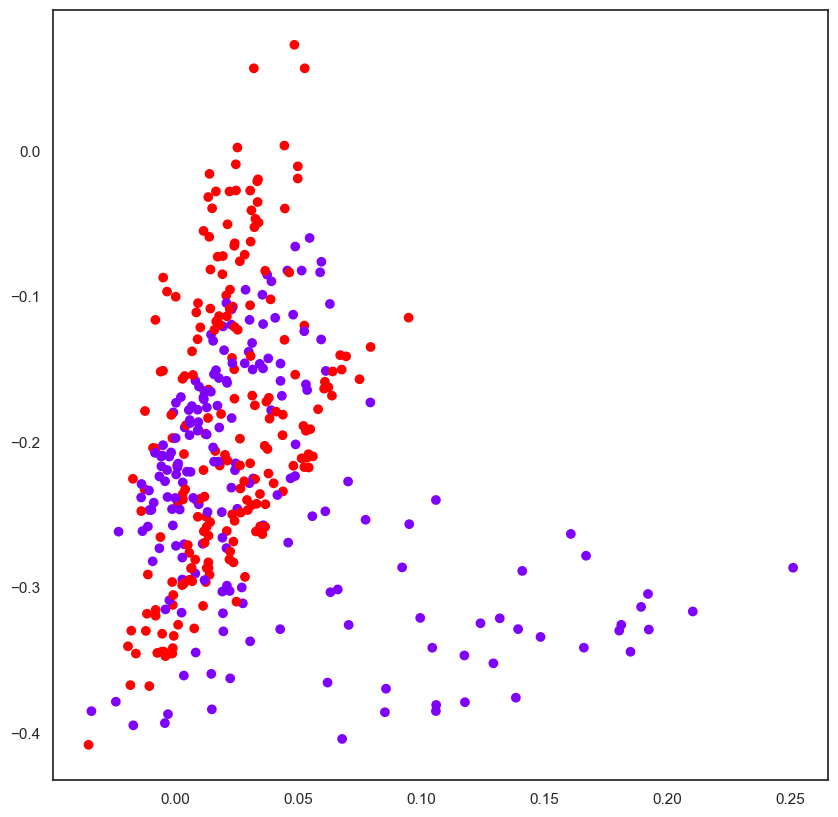

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(mean[:, 0], mean[:, 1], c=labels_test, cmap='rainbow')
plt.show()


Epoch 1/2000, Loss: 31.767282485961914, MSE: 0.34447944164276123
Epoch 11/2000, Loss: 25.73263168334961, MSE: 0.2466498464345932
Epoch 21/2000, Loss: 22.747241973876953, MSE: 0.18748143315315247
Epoch 31/2000, Loss: 20.690662384033203, MSE: 0.15835195779800415
Epoch 41/2000, Loss: 19.465572357177734, MSE: 0.14561960101127625
Epoch 51/2000, Loss: 18.41656494140625, MSE: 0.13992920517921448
Epoch 61/2000, Loss: 17.087188720703125, MSE: 0.13714714348316193
Epoch 71/2000, Loss: 16.09842300415039, MSE: 0.13552728295326233
Epoch 81/2000, Loss: 15.193967819213867, MSE: 0.13364064693450928
Epoch 91/2000, Loss: 14.226027488708496, MSE: 0.13159756362438202
Epoch 101/2000, Loss: 13.63438606262207, MSE: 0.1296093761920929
Epoch 111/2000, Loss: 12.765230178833008, MSE: 0.12754212319850922
Epoch 121/2000, Loss: 12.125157356262207, MSE: 0.12476032972335815
Epoch 131/2000, Loss: 11.29671573638916, MSE: 0.1218753233551979
Epoch 141/2000, Loss: 10.675253868103027, MSE: 0.11692321300506592
Epoch 151/2000

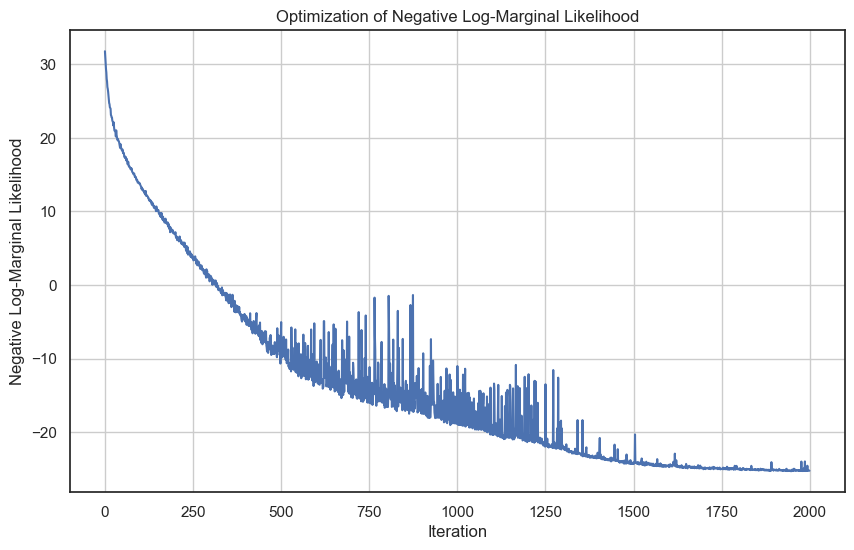

In [9]:
model_settings['data_dim'] = yn_train.shape[-1]
batch_shape = torch.Size([model_settings['data_dim']])

if model_settings['use_gpytorch'] is False:
    kernel_cls = ARDRBFKernel(input_dim=model_settings['latent_dim'])
    kernel_reg = ARDRBFKernel(input_dim=model_settings['latent_dim'])
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))
else:
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))

likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
likelihood_cls = BernoulliLikelihood()

model = JointGPLVM_Bayesian(yn_train,
                            kernel_reg=kernel_reg,
                            kernel_cls=kernel_cls,
                            num_classes=ys_train.shape[-1],
                            latent_dim=model_settings['latent_dim'],
                            num_inducing_points_reg=model_settings['num_inducing_points_reg'],
                            num_inducing_points_cls=model_settings['num_inducing_points_cls'],
                            num_inducing_points=model_settings['num_inducing_points'],
                            likelihood_reg=likelihood_reg,
                            likelihood_cls=likelihood_cls,
                            use_gpytorch=model_settings['use_gpytorch'],
                            shared_inducing_points=model_settings['shared_inducing_points'],
                            use_shared_kernel=model_settings['use_shared_kernel'],
                            cls_weight=model_settings['cls_weight'],
                            reg_weight=model_settings['reg_weight'],
                            random_state=random_state)

if model_settings['load_trained_model'] is False:
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'])
    model.save_wights(path_save=paths.path_model[0])

    with open(paths.path_model[0] + 'model_settings.json', 'w') as f:
        json.dump(model_settings, f, indent=2)
else:
    losses = []
    model.load_weights(paths.model)